In [1]:
# Initialization
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

raw_tr = pd.read_csv("data/train.csv")
raw_tr = raw_tr.replace(to_replace=-999, value=np.nan)

raw_te = pd.read_csv("data/test.csv")
raw_te = raw_te.replace(to_replace=-999, value=np.nan)

os.chdir("utils")

In [2]:
# Explore NaNs
nans = raw_tr.isnull() 
nan_cols = nans.sum(axis=0) / raw_tr.shape[0]
nan_rows = nans.sum(axis=1)

with pd.option_context('display.float_format','{:.4%}'.format):
    print("NaN column summary:\n{}\n".format(nan_cols[nan_cols > 0]))
print("NaN row summary:\n{}".format(nan_rows[nan_rows > 0]))

print("\nShapes")
print("\traw: {}".format(raw_tr.shape))
print("\tdrop rows: {}".format(raw_tr.dropna(axis=0).shape))
print("\tdrop cols: {}".format(raw_tr.dropna(axis=1).shape))

NaN column summary:
DER_mass_MMC             15.2456%
DER_deltaeta_jet_jet     70.9828%
DER_mass_jet_jet         70.9828%
DER_prodeta_jet_jet      70.9828%
DER_lep_eta_centrality   70.9828%
PRI_jet_leading_pt       39.9652%
PRI_jet_leading_eta      39.9652%
PRI_jet_leading_phi      39.9652%
PRI_jet_subleading_pt    70.9828%
PRI_jet_subleading_eta   70.9828%
PRI_jet_subleading_phi   70.9828%
dtype: float64

NaN row summary:
1          7
2          8
3         10
4         10
7          7
          ..
249995    11
249996    11
249997     7
249998    10
249999    11
Length: 181886, dtype: int64

Shapes
	raw: (250000, 32)
	drop rows: (68114, 32)
	drop cols: (250000, 21)


In [188]:
################################################################################
# Prepare data and labels
################################################################################

# Drop rows with NaNs
#data = raw.dropna(axis=0)

# Drop columns with NaNs
#data = raw.dropna(axis=1)

# Replace NaNs with mean of the column
#means = raw_tr.means()
#train = raw_tr.fillna(means)
#test = raw_te.fillna(means)

# Signal = 1, Background = 0
train = raw_tr.replace({'s':1,'b':0})
test = raw_te.replace({'s':1,'b':0})

# Split data and labels
X = train.drop(columns=['Id','Prediction'])
y = train['Prediction']

# Standarize data
from utils.helpers import standardize
X, mean, std = standardize(X)

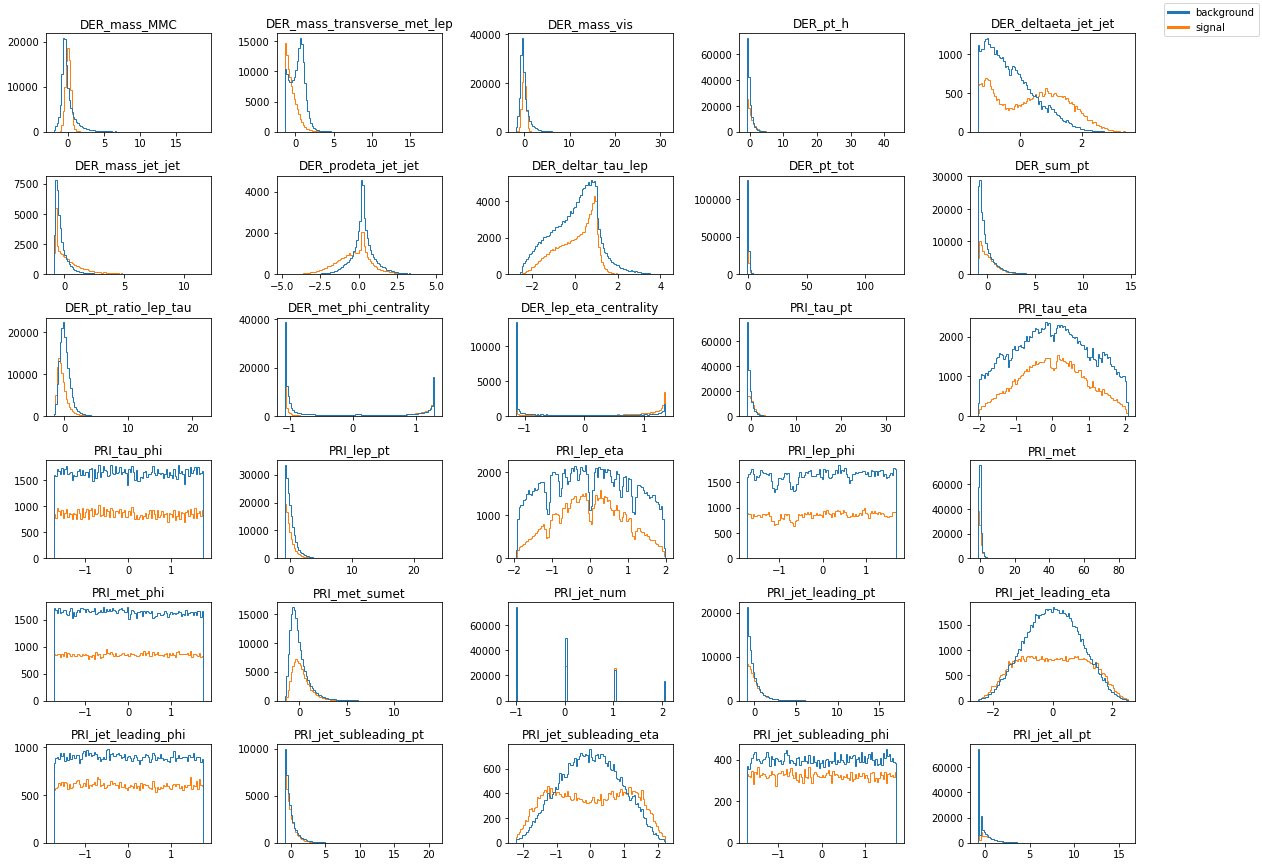

In [4]:
from matplotlib.lines import Line2D
def plot_histogram(y, X):
    mask = (y == 0)
    labels = ("background","signal")
    n = X.shape[1]
    
    nrows = (n+4)//5
    ncols = 5
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(16,12))
    
    for k, name in enumerate(X):
        row = k // ncols
        col = k % ncols
        axs[row, col].hist([X[name][mask], X[name][~mask]], 
                 label=labels, 
                 bins=100, 
                 histtype='step');
        axs[row, col].set_title(name)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    fig.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()

plot_histogram(y, X)

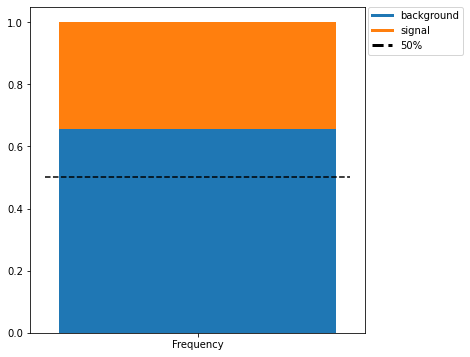

In [5]:
def plot_bar_counts(y, X):
    width = 0.5
    idx = (1,)
    labels = ("background","signal","50%")
    
    vals, counts = np.unique(y, return_counts=True)
    assert (len(vals) == 2)
    
    b = counts[vals == 0] / y.shape[0]
    s = counts[vals == 1] / y.shape[0]

    plt.figure(figsize=(6,6))
    plt.bar(idx, b, width)
    plt.bar(idx, s, width, bottom=b)
    plt.xticks(idx, ('Frequency',))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    
    left, right = plt.xlim()
    plt.hlines(0.5, left, right, linestyle='--')
    colors.append('black')
    lines.append(Line2D([0], [0], color='black', linewidth=3, linestyle='--'))
    
    plt.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plot_bar_counts(y, X)

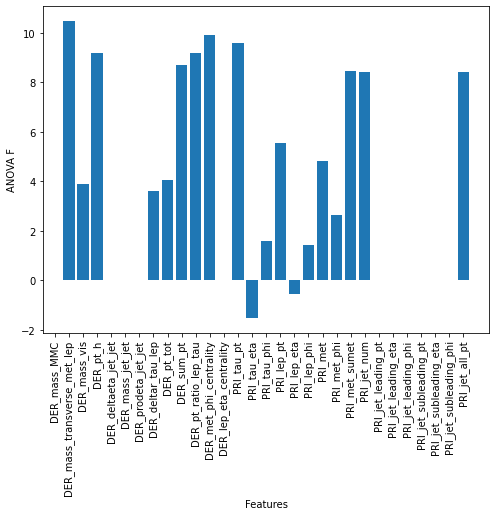

In [6]:
from scipy import stats

# ANOVA:
#  - https://dzone.com/articles/correlation-between-categorical-and-continuous-var-1

corr = np.empty(train.shape[1]-2)
cols = [col for col in train.drop(columns=['Id','Prediction'])]

for j, col in enumerate(cols):
    F, p = stats.f_oneway(train[train['Prediction']==0][col],
                          train[train['Prediction']==1][col])
    corr[j] = F

idx = np.arange(corr.shape[0])
plt.figure(figsize=(8,6))
plt.bar(idx, np.log(corr))
plt.xticks(idx, cols, rotation=90)
plt.xlabel('Features')
plt.ylabel('ANOVA F')
plt.show()

-----------------------------------------------
# Prepare Features
-----------------------------------------------

In [198]:
def build_poly(x, degree):
    """polynomial basis functions for each column of x, for j=1 up to j=degree, and single constant term."""
    if (degree < 0): raise ValueError("degree must be positive")
    
    phi = np.empty((x.shape[0], x.shape[1]*degree+1))
    
    # Constant term
    phi[:,-1] = 1
    
    # Higher order terms
    for j in range(x.shape[1]):
        phi[:,j*degree] = x[:,j]
        for d in range(1,degree):
            col = j*degree+d
            phi[:,col] = phi[:,col-1] * x[:,j]
    
    return phi

def standardize_numpy(x):
    """Standardize the original data set. Works on numpy arrays."""
    mean_x = x.mean(axis=0, keepdims=True)
    x = x - mean_x
    std_x = x.std(axis=0, keepdims=True)
    x = x / std_x
    return x, mean_x, std_x

def prepare_feautres(tx_nan, degree, mean=None): 
    # Get column means, if necessary
    if mean is None:
        mean = np.nanmean(tx_nan,axis=0)
    # Replace NaNs
    tx = np.where(np.isnan(tx_nan), mean, tx_nan)
    
    # Augment features
    tx = build_poly(tx, degree)
    const_col = tx.shape[1]-1
    
    # Add NaN indicator columns
    nan_cols = np.flatnonzero(np.any(np.isnan(tx_nan), axis=0))

    ind_cols = np.empty((tx_nan.shape[0], nan_cols.shape[0]))
    ind_cols = np.where(np.isnan(tx_nan[:,nan_cols]), 1, 0)

    tx = np.c_[tx, ind_cols]
    
    # Standardize
    tx, _, _ = standardize_numpy(tx)
    tx[:,const_col] = 1.0
    
    return tx, mean, nan_cols

--------------------------------------------
# Hyper-Parameter Selection
--------------------------------------------

In [193]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    if (ratio < 0 or ratio > 1): raise ValueError("ratio must be in [0,1]")
    # set seed
    np.random.seed(seed)
    
    # Random permutation
    idx = np.random.permutation(y.shape[0])
    split = int(ratio * y.shape[0])
    
    x_tr = x[idx[:split]]
    y_tr = y[idx[:split]]
    
    x_te = x[idx[split:]]
    y_te = y[idx[split:]]
    
    return x_tr, y_tr, x_te, y_te

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [199]:
from utils.implementations import reg_logistic_regression
from utils.costs import reg_logistic_error
from utils.helpers import sigmoid
from utils.cross_validation import *

def cross_validation(y, x, degree, k_indices, k, lambda_, gamma, reg, max_iters):
    # get k'th subgroup in test, others in train
    mask = np.full((y.shape[0]), False, dtype=bool)
    mask[k_indices[k]] = True
    
    y_te = y[mask]
    x_te = x[mask]
    
    mask = ~mask
    y_tr = y[mask]
    x_tr = x[mask]
    
    # Replace NaNs and standarize
    x_tr, mean, _ = prepare_feautres(x_tr, degree)
    x_te, _, _ = prepare_feautres(x_te, degree, mean)
    
    # ridge regression
    w, loss = reg_logistic_regression(
                y=y_tr,
                tx=x_tr,
                initial_w=np.ones((x_tr.shape[1])),
                max_iters=max_iters,
                reg=reg,
                lambda_=lambda_,
                gamma=gamma,
                batch_size = 1 # Stochastic Gradient Descent
            )
    
    # calculate the loss for train and test data    
    loss_tr = reg_logistic_error(y_tr, x_tr, w, lambda_, reg)
    loss_te = reg_logistic_error(y_te, x_te, w, lambda_, reg)
    
    p = np.rint(sigmoid(x_te @ w))
    f1 = f1_score(y_te, p)
    acc = accuracy(y_te, p)
    
    return loss_tr, loss_te, f1, acc, w


def model_selection(y, tx, k_fold, degree, seeds, gammas, lambdas, max_iters, reg, verbose=2):
    
    max_loss = np.finfo(float).min
    max_acc = np.finfo(float).min
    
    all_loss = np.zeros((len(seeds),len(gammas),len(lambdas)))
    all_f1 = np.zeros((len(seeds),len(gammas),len(lambdas)))
    all_acc = np.zeros((len(seeds),len(gammas),len(lambdas)))
    
    print(f'Trainig on {int((1-1/k_fold)*y.shape[0])} samples')
    for s, seed in enumerate(seeds):
        print(f'Seed {seed}')
        k_indices = build_k_indices(y, k_fold, seed)
        for l, lambda_ in enumerate(lambdas):
            print(f'\Lambda {lambda_:.4e}')
            for g, gamma in enumerate(gammas):
                # Cross validation
                loss_tr = 0.0
                loss_te = 0.0
                f1_te = 0.0
                acc_te = 0.0
                for k in range(k_fold):
                    tr, te, f1, acc, w = cross_validation(y, tx, degree, k_indices, k, lambda_, gamma, reg, max_iters)
                    loss_tr += tr
                    loss_te += te
                    f1_te += f1
                    acc_te += acc
                    
                    if verbose > 1:
                        print(f'\t\t\tTR={tr:.4e} | TE={te:.4e} | F1:{f1:.4f} | ACC:{acc:.4f}')
                        
                    if ~np.all(np.isfinite((tr, te, f1, acc))): break
                
                loss_tr /= k+1
                loss_te /= k+1
                f1_te /= k+1
                acc_te /= k+1
                all_loss[s, g, l] = loss_te
                all_f1[s, g, l] = f1_te
                all_acc[s, g, l] = acc_te
            
                if verbose > 0:
                    print(f'\t\tgamma {gamma:.4e}: TR={loss_tr:.4e} | TE={loss_te:.4e} | F1:{f1_te:.4f} | ACC:{acc_te:.4f}')
                
                if max_acc < acc_te:
                    min_loss = loss_te
                    min_lambda = lambda_
                    min_gamma = gamma
                    max_f1 = f1_te
                    max_acc = acc_te
    
    print(f'\nMINIMUMS:')
    print(f'\tlambda={min_lambda:.4e}')
    print(f'\tgamma={min_gamma:.4e}')
    print(f'\tTest loss={min_loss:.4e}')
    print(f'\tAccuracy={max_acc:.4f}')
    
    return max_acc, min_lambda, min_gamma, all_loss, all_f1, all_acc

In [200]:
gammas = np.logspace(-1, 0, 5)   # Learning rate
lambdas = np.logspace(-2, 0, 5)  # Regularization term
#seeds = (42, 1729, 12345)
seeds = (42,)
max_iters = 100
reg = 2 # L2 regularization
k_fold = 4
verbose = 2

degree = 3

tx = np.asarray(train.drop(columns=['Id','Prediction']))
y = np.asarray(train['Prediction'])
max_acc, min_lambda, min_gamma, all_loss, all_f1, all_acc = model_selection(y, tx, k_fold, degree, seeds, gammas, lambdas, max_iters, reg, verbose)

Trainig on 187500 samples
Seed 42
	Gamma 1.0000e-01


<ipython-input-198-636cc053d1f8>:24: RuntimeWarning: invalid value encountered in true_divide
  x = x / std_x
/home/david/EPFL/courses/ML/project/Project_1/utils/helpers.py:108: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-x))
/home/david/EPFL/courses/ML/project/Project_1/utils/costs.py:67: RuntimeWarning: divide by zero encountered in log
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))
/home/david/EPFL/courses/ML/project/Project_1/utils/costs.py:67: RuntimeWarning: invalid value encountered in multiply
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))


			TR=2.9585e+00 | TE=2.8267e+00 | F1:0.5614 | ACC:0.6639
			TR=2.9160e+00 | TE=3.1213e+00 | F1:0.5497 | ACC:0.6775
			TR=2.9175e+00 | TE=3.1920e+00 | F1:0.5491 | ACC:0.6790
			TR=2.9305e+00 | TE=3.1344e+00 | F1:0.5443 | ACC:0.6741
		lambda 1.0000e-02: TR=2.9306e+00 | TE=3.0686e+00 | F1:0.5511 | ACC:0.6736
			TR=2.0204e+00 | TE=1.9433e+00 | F1:0.5882 | ACC:0.6949
			TR=2.0141e+00 | TE=2.1492e+00 | F1:0.5682 | ACC:0.6976
			TR=2.0143e+00 | TE=2.1995e+00 | F1:0.5644 | ACC:0.6970
			TR=2.0203e+00 | TE=2.1620e+00 | F1:0.5613 | ACC:0.6936
		lambda 3.1623e-02: TR=2.0173e+00 | TE=2.1135e+00 | F1:0.5705 | ACC:0.6958
			TR=9.9274e-01 | TE=9.8349e-01 | F1:0.6078 | ACC:0.7347
			TR=9.9834e-01 | TE=1.0206e+00 | F1:0.5941 | ACC:0.7291
			TR=9.9794e-01 | TE=1.0298e+00 | F1:0.5929 | ACC:0.7295
			TR=9.9813e-01 | TE=1.0223e+00 | F1:0.5893 | ACC:0.7267
		lambda 1.0000e-01: TR=9.9678e-01 | TE=1.0141e+00 | F1:0.5960 | ACC:0.7300
			TR=7.9574e-01 | TE=7.9535e-01 | F1:0.5933 | ACC:0.7299
			TR=7.9611e-01 |

/home/david/EPFL/courses/ML/project/Project_1/utils/costs.py:67: RuntimeWarning: divide by zero encountered in log
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))


			TR=inf | TE=1.2883e+00 | F1:0.6322 | ACC:0.7719
		lambda 1.0000e-02: TR=inf | TE=1.2883e+00 | F1:0.6322 | ACC:0.7719
			TR=1.1224e+00 | TE=1.1214e+00 | F1:0.6212 | ACC:0.7636
			TR=1.1230e+00 | TE=1.1255e+00 | F1:0.6169 | ACC:0.7614
			TR=1.1232e+00 | TE=1.1289e+00 | F1:0.6159 | ACC:0.7599
			TR=1.1242e+00 | TE=1.1289e+00 | F1:0.6166 | ACC:0.7610
		lambda 3.1623e-02: TR=1.1232e+00 | TE=1.1262e+00 | F1:0.6176 | ACC:0.7615
			TR=1.1781e+00 | TE=1.1603e+00 | F1:0.5498 | ACC:0.7022
			TR=9.2764e-01 | TE=9.2780e-01 | F1:0.6164 | ACC:0.7309
			TR=1.1400e+00 | TE=1.1491e+00 | F1:0.5535 | ACC:0.7032
			TR=1.1444e+00 | TE=1.1469e+00 | F1:0.5456 | ACC:0.6986
		lambda 1.0000e-01: TR=1.0975e+00 | TE=1.0960e+00 | F1:0.5663 | ACC:0.7087
			TR=8.5913e-01 | TE=8.5971e-01 | F1:0.4469 | ACC:0.4727
			TR=8.4919e-01 | TE=8.5029e-01 | F1:0.4553 | ACC:0.4809
			TR=8.5274e-01 | TE=8.4903e-01 | F1:0.4510 | ACC:0.4773
			TR=8.4980e-01 | TE=8.4977e-01 | F1:0.4575 | ACC:0.4820
		lambda 3.1623e-01: TR=8.5272e-

/home/david/EPFL/courses/ML/project/Project_1/utils/costs.py:67: RuntimeWarning: invalid value encountered in multiply
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))


			TR=nan | TE=nan | F1:0.5483 | ACC:0.7096
		lambda 1.0000e-02: TR=nan | TE=nan | F1:0.5483 | ACC:0.7096
			TR=2.3989e+00 | TE=2.3168e+00 | F1:0.5263 | ACC:0.6861
			TR=2.3335e+00 | TE=2.3560e+00 | F1:0.5196 | ACC:0.6804
			TR=nan | TE=nan | F1:0.5458 | ACC:0.6411
		lambda 3.1623e-02: TR=nan | TE=nan | F1:0.5306 | ACC:0.6692
			TR=nan | TE=inf | F1:0.4729 | ACC:0.5104
		lambda 1.0000e-01: TR=nan | TE=inf | F1:0.4729 | ACC:0.5104
			TR=4.8124e+00 | TE=4.7338e+00 | F1:0.4561 | ACC:0.6353
			TR=4.6860e+00 | TE=4.7059e+00 | F1:0.4574 | ACC:0.6323
			TR=4.6778e+00 | TE=4.7268e+00 | F1:0.4591 | ACC:0.6341
			TR=4.7047e+00 | TE=4.7083e+00 | F1:0.4541 | ACC:0.6309
		lambda 3.1623e-01: TR=4.7202e+00 | TE=4.7187e+00 | F1:0.4567 | ACC:0.6332
			TR=nan | TE=nan | F1:0.4377 | ACC:0.6291
		lambda 1.0000e+00: TR=nan | TE=nan | F1:0.4377 | ACC:0.6291

MINIMUMS:
	lambda=1.0000e-02
	gamma=5.6234e-01
	Test loss=1.2883e+00
	Accuracy=0.7719


/home/david/EPFL/courses/ML/project/Project_1/utils/helpers.py:108: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-x))


In [206]:
# Save expensive computation
#%store all_loss all_f1 all_acc min_gamma min_lambda
#%store -r all_loss all_f1 all_acc min_gamma min_lambda

#MINIMUMS:
#	lambda 1.0000e-02
#	gamma 5.6234e-01
#	Test loss=1.2887e+00
#	Accuracy=7.7218e-01

Stored 'all_loss' (ndarray)
Stored 'all_f1' (ndarray)
Stored 'all_acc' (ndarray)
Stored 'min_gamma' (float64)
Stored 'min_lambda' (float64)


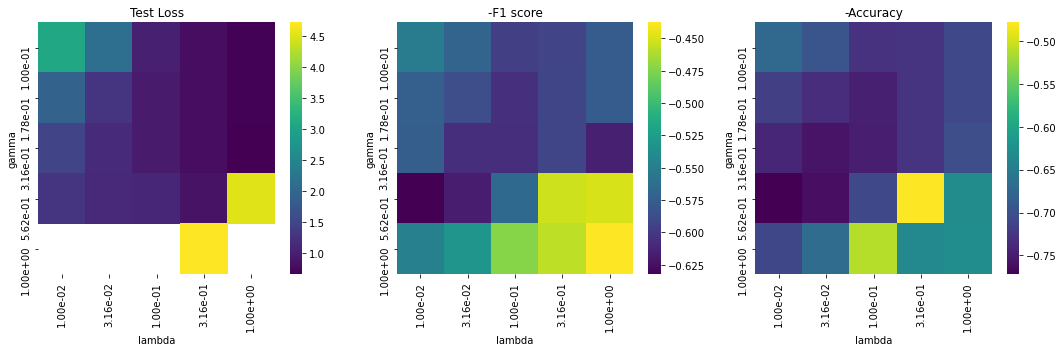

In [202]:
import seaborn as sns

def plot_heatmap(ax, vals, title):
    mask = ~np.isfinite(vals)
    sns.heatmap(vals,
        mask=mask, 
        xticklabels=[f'{x:.2e}' for x in lambdas], 
        yticklabels=[f'{x:.2e}' for x in gammas],
        ax=ax,
        cmap='viridis')
    ax.set_xlabel('lambda')
    ax.set_ylabel('gamma')
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_heatmap(axs[0], all_loss.mean(axis=0), 'Test Loss')
plot_heatmap(axs[1], -all_f1.mean(axis=0), '-F1 score')
plot_heatmap(axs[2], -all_acc.mean(axis=0), '-Accuracy')

fig.tight_layout()

----------------------------------------------------------------
# Train
----------------------------------------------------------------
Train model on all data with optimal hyper-parameters.

In [203]:
from utils.costs import logistic_error
from utils.helpers import sigmoid

# Prepare training and test data
tx_tr = np.asarray(train.drop(columns=['Id','Prediction']))
y_tr = np.asarray(train['Prediction'])

tx_te = np.asarray(test.drop(columns=['Id','Prediction']))

tx_tr, mean, nan_cols = prepare_feautres(tx_tr, degree)
tx_te, _, _ = prepare_feautres(tx_te, degree, mean)

# Train model
w, loss = reg_logistic_regression(
                y=y_tr,
                tx=tx_tr,
                initial_w=np.ones((tx_tr.shape[1])),
                lambda_=min_lambda,
                gamma=min_gamma,
                max_iters=max_iters,
                batch_size=1, # Stochastic Gradient Descent
                reg=reg)

# Report results
loss_tr = logistic_error(y_tr, tx_tr, w)
y_pred = np.rint(sigmoid(tx_tr @ w))
f1 = f1_score(y_tr, y_pred)
acc = accuracy(y_tr, y_pred)

print('RESULTS:')
print(f'\tlambda:   {min_lambda:.4e}')
print(f'\tgamma:    {min_gamma:.4e}')
print(f'\tLoss:     {loss_tr:.4e}')
print(f'\tF1 score: {f1:.4f}')
print(f'\tAccuracy: {acc:.4f}')

<ipython-input-198-636cc053d1f8>:24: RuntimeWarning: invalid value encountered in true_divide
  x = x / std_x


RESULTS:
	lambda:   1.0000e-02
	gamma:    5.6234e-01
	Loss:     inf
	F1 score: 0.6297
	Accuracy: 0.7705


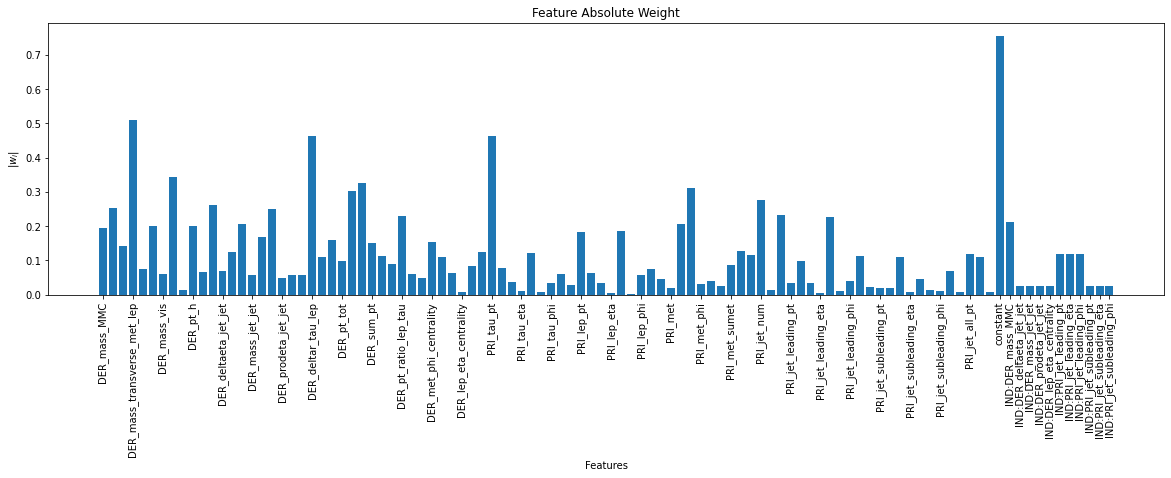

In [204]:
# Plot feature weights
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(w.shape[0]), abs(w))

col_names = [col for col in train.drop(columns=['Id','Prediction'])]
labels = col_names + ['constant'] + [f'IND:{col}' for col in train.drop(columns=['Id','Prediction']).iloc[:,nan_cols]]
idx = np.arange(len(labels)) 
idx[:len(col_names)+1] *= degree
idx[len(col_names)+1:] += idx[len(col_names)] - idx[len(col_names)+1] + 1
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Features')
plt.ylabel('$|w_i|$')
plt.title('Feature Absolute Weight');

-------------------------------------
# Generate Submission
-------------------------------------

In [205]:
from utils.helpers import create_csv_submission
import importlib

ids = test['Id']
y_pred = np.rint(sigmoid(tx_te @ w))
y_pred[y_pred == 0] = -1
y_pred[y_pred == 1] = 1

create_csv_submission(ids, y_pred, '../submission.csv')

### NOTES
 - It seems that adding the missing value indicators makes the method more "consitent with expectation". 
That is, the test loss and accuracy now follow similar patterns (both go up/down together). Without them, the highest accuracy tended to be where the test loss "blew up" (inf or nan). 
- While the local CV did not make much difference between imputing NaNs with the median or mean, i=on AIcrowd the prediction using the mean was better (0.744 -> 0.761)